In [1]:
import os
import json
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [2]:
np.random.seed(21)

In [3]:
from keras import backend as K
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.layers import Dense, AvgPool2D, Conv2D, Reshape
from keras.models import Model, load_model
from keras.optimizers import RMSprop, SGD
from keras.losses import categorical_crossentropy
from keras.preprocessing.image import Iterator
from keras.utils.np_utils import to_categorical
import tensorflow as tf
sess = tf.Session()
K.set_session(sess)

Using TensorFlow backend.


In [4]:
class NonValidPatch(Exception):
    pass

In [5]:
def get_block_loc(shape, x, y, target_size=(224, 224), n_blocks=(4,4), overlap=(448,448)):
    h, w = shape
    w_block = (w + (n_blocks[1] - 1) * overlap[1]) // n_blocks[1]
    h_block = (h + (n_blocks[0] - 1) * overlap[0]) // n_blocks[0]
    for by in range(n_blocks[0]):
        y_start = by * (h_block - overlap[0])
        y_end = y_start + h_block + 1
        for bx in range(n_blocks[1]):
            x_start = bx * (w_block - overlap[1])
            x_end = x_start + w_block + 1
            
            if x_start <= x < x_end and y_start <= y < y_end and\
            x_start <= x + target_size[1] - 1 < x_end and y_start <= y + target_size[0] - 1 < y_end:
                return bx + by * n_blocks[0], x - x_start, y - y_start
    raise NonValidPatch("Can't find block...??")

In [6]:
class StreamStats(object):
    """ See https://www.johndcook.com/blog/standard_deviation/
    """
    def __init__(self):
        self.M = None
        self.S = None
        self.k = 0
        self.min = None
        self.max = None
        
    def update(self, x):
        self.k += 1
        if self.k == 1:
            self.M = x
            self.S = 0
            self.min = x
            self.max = x
        else:
            prevM = self.M
            prevS = self.S
            self.M = prevM + (x - prevM)/self.k
            self.S = prevS + (x - prevM) * (x - self.M)
            self.min = np.minimum(x, self.min)
            self.max = np.maximum(x, self.max)
            
    def mean(self):
        return self.M
        
    def variance(self):
        if self.k - 1 > 0:
            return self.S / (self.k - 1)
        else:
            return 0
    
    def std(self):
        return np.sqrt(self.variance())
    
    def minimum(self):
        return self.min
    
    def maximum(self):
        return self.max

In [7]:
class PatchIterator(Iterator):
    """Iterator yielding training samples
    :param root_dir: Directory containing training images, and dots.
    :param image_ids: Set of image ids to use to sample patches.
    :param class_weights: Weights for each class.
    :param n_samples_per_image: Number of patches to sample on each image.
    :param target_size: Size of the patches sampled.
    :param batch_size: Number of patches sampled per batch
    :param shuffle: Boolean, whether to shuffle the data between epochs.
    :param seed: Random seed for data shuffling.
    :return batch_x, batch_x. 
        batch_x is a (batch_size, target_size[0], target_size[1], 3) array
        batch_x is a (batch_size, target_size[0], target_size[1], 1) array if output_counts is False
        otherwise, it is a (batch_size, 5) array.
    """

    def __init__(self, root_dir, image_ids,
                 class_weights = None,
                 n_samples_per_image=160,
                 target_size=(91, 91),
                 batch_size=32, shuffle=True, seed=42, debug_dir=None):
        
        self.n_sealion_types = 5
        self.image_ids = image_ids
        self.root_dir = root_dir
        self.debug_dir = debug_dir
        # Normalize to use class_weights as a probability distribution.
        if class_weights:
            self.class_weights = np.asarray(class_weights)/np.sum(class_weights)
        else:
            self.class_weights = np.ones((self.n_sealion_types+1))/(self.n_sealion_types + 1)
            
        self.n_samples_per_image = n_samples_per_image
        self.target_size = target_size
        self.n_indices = len(self.image_ids) * self.n_samples_per_image
                 
        super(PatchIterator, self).__init__(self.n_indices, batch_size, shuffle, seed)
    
    def normalize_input(self, x):
        return preprocess_input(x)
    
    def denormalize_input(self, x_normed):
        x = x_normed / 2
        x += 0.5
        x *= 255
        return np.clip(x, 0, 255)
    
    def random_transform(self, im):
        flip_hor = np.random.randint(0, 2)
        flip_ver = np.random.randint(0, 2)
        if flip_hor == 1:
            im = cv2.flip(im, 0)
        if flip_ver == 1:
            im = cv2.flip(im, 1)
        return im
    
    def sample(self, shape, dots, image_id):
        # if more than 30% of the patch is masked, reject it
        threshold_masked = 0.3 
        
        # Set probability to 0 if some sealion type is not in the block
        current_weigths = self.class_weights.copy()
        for i in range(self.n_sealion_types):
            if not dots[i]:
                current_weigths[i] = 0
        current_weigths /= np.sum(current_weigths)

        while 1:
            # Choose an output class randomly
            output_class = np.random.choice(self.n_sealion_types + 1, size=(1, ), p=current_weigths)[0]

            try:
                # Sample a location, either for background or for a sealion.
                if output_class == self.n_sealion_types:
                    x, y = self.sample_bg(shape, dots, image_id)
                else:
                    x, y = self.sample_dot(shape, dots[output_class], image_id)
            
                # Get the corresponding image block, and (x, y) in this block
                bid, x, y = get_block_loc(shape, x, y)
            except NonValidPatch:
                continue
            
            uid = "{iid}_{bid}".format(iid=image_id, bid=bid)
            img = cv2.imread(os.path.join(self.root_dir, "TrainBlock", uid + ".jpg"))
            if img is None:
                continue
            img_patch = img[y:y+self.target_size[0], x:x+self.target_size[1],:]
            masked_pixels = np.count_nonzero(img_patch == 0)
            total_pixels = img_patch.shape[0] * img_patch.shape[1]
            if img_patch.shape[0] != self.target_size[0] or img_patch.shape[1] != self.target_size[1]:
                continue
            if masked_pixels/total_pixels < threshold_masked:
                img_patch_rgb = img_patch[...,::-1]
                return self.random_transform(img_patch_rgb), output_class
        
    def contains_dots(self, xstart, ystart, dots):
        xend = xstart + self.target_size[1]
        yend = ystart + self.target_size[0]
        for ds in dots:
            for (x, y) in ds:
                if xstart <= x < xend and ystart <= y < yend:
                    return True
        return False
    
    def sample_bg(self, shape, dots, image_id):
        max_iterations = 10
        current_iteration = 0
        while current_iteration < max_iterations:
            x = np.random.randint(0, shape[1] - self.target_size[1], size=(1,))[0]
            y = np.random.randint(0, shape[0] - self.target_size[0], size=(1,))[0]
            if not self.contains_dots(x, y, dots):
                return x, y
            current_iteration += 1
        raise NonValidPatch("Cant' find background")
    
    def sample_dot(self, shape, dots, image_id):
        margin = self.target_size[0]//8
        
        rand_index = np.random.choice(len(dots), size=(1,))[0]
        rand_dot = dots[rand_index]
        
        min_x = max(0, rand_dot[0] - self.target_size[1]//2 - margin)
        max_x = min(shape[1] - self.target_size[1], rand_dot[0] - self.target_size[1]//2 + margin)
        
        min_y = max(0, rand_dot[1] - self.target_size[0]//2 - margin)
        max_y = min(shape[0] - self.target_size[0], rand_dot[1] - self.target_size[0]//2 + margin)
        
        if min_x > max_x:
            max_x, min_x = min_x, max_x
        if min_y > max_y:
            max_y, min_y = min_y, max_y 
            
        if min_x == max_x or min_y == max_y:
            raise NonValidPatch()
           
        x = np.random.randint(min_x, max_x, size=(1,))[0]
        y = np.random.randint(min_y, max_y, size=(1,))[0]
        
        return x, y
        
    def next(self):
        """For python 2.x.
        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
                 
        batch_x = np.zeros((current_batch_size, self.target_size[0], self.target_size[1], 3), dtype=K.floatx())
        batch_y = np.zeros((current_batch_size), dtype=np.int32)
        
        # For each index, we load the data and sample randomly n_successive_samples patches
        for i, j in enumerate(index_array):
            index = j // self.n_samples_per_image
            image_id = self.image_ids[index]
            with open(os.path.join(self.root_dir, "TrainDotsB", str(image_id) + ".pkl"), "rb") as pfile:
                dots = pickle.load(pfile)
            with open(os.path.join(self.root_dir, "TrainShape", str(image_id) + ".pkl"), "rb") as pfile:
                shape = pickle.load(pfile)
                
            x, y = self.sample(shape, dots, image_id)
            batch_x[i, ...] = x
            batch_y[i] = y 

        if self.debug_dir:
            for i in range(current_batch_size):
                cv2.imwrite(os.path.join(self.debug_dir, "patch_{}.jpg".format(i)), batch_x[i])
                
        return self.normalize_input(batch_x), to_categorical(batch_y, num_classes=self.n_sealion_types + 1).reshape(-1, 1, 1, self.n_sealion_types + 1)

In [8]:
with open("../data/sealion/train.json", "r") as jfile:
    train_ids = json.load(jfile)
train_ids = [int(s[:-4]) for s in train_ids]

with open("../data/sealion/dots_ok.json", "r") as jfile:
    dots_ok = json.load(jfile)
dots_ok = [int(s[:-4]) for s in dots_ok]

train_ids = list(set(train_ids).intersection(set(dots_ok)))

with open("../data/sealion/val.json", "r") as jfile:
    val_ids = json.load(jfile)
val_ids = [int(s[:-4]) for s in val_ids]
val_ids = list(set(val_ids).intersection(set(dots_ok)))

In [9]:
sealion_types = ["adult_males", 
    "subadult_males",
    "adult_females",
    "juveniles",
    "pups"]

In [10]:
class_weights = [0.34,  0.42, 0.05, 0.09, 0.11, 1/5]

In [11]:
trainPatchesGenerator = PatchIterator("/home/lowik/sealion/data/sealion/", train_ids, class_weights=class_weights)

In [12]:
valPatchesGenerator = PatchIterator("/home/lowik/sealion/data/sealion/", val_ids, class_weights=class_weights)

Create model

In [13]:
base_model = Xception(weights='imagenet', include_top=False, pooling=None)

In [14]:
x = base_model.output
x = AvgPool2D(pool_size=(3, 3), strides=(1, 1))(x)
predictions_fc = Conv2D(len(sealion_types) + 1, (1, 1), activation='softmax', name='predictions')(x)
#predictions = Dense(len(sealion_types) + 1, activation='softmax', name='predictions')(x)

In [15]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions_fc)

In [16]:
for layer in base_model.layers:
    layer.trainable = False

In [17]:
sgd = SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=True)
model.compile(optimizer=sgd, loss=categorical_crossentropy, metrics=['accuracy'])

In each epoch, we will do 32 * 300 = 9600 samples

In [18]:
h = model.fit_generator(trainPatchesGenerator, 300, epochs=3, verbose=1, callbacks=None, validation_data=valPatchesGenerator, validation_steps=50, class_weight=None, max_q_size=10, workers=1, pickle_safe=False, initial_epoch=0)

Epoch 1/3
300/300 [==============================] - 958s - loss: 1.3386 - acc: 0.5026 - val_loss: 1.1630 - val_acc: 0.5563
Epoch 2/3
300/300 [==============================] - 823s - loss: 1.2066 - acc: 0.5375 - val_loss: 1.1591 - val_acc: 0.5394
Epoch 3/3
300/300 [==============================] - 750s - loss: 1.1495 - acc: 0.5503 - val_loss: 1.1502 - val_acc: 0.5506


In [19]:
model.save("../data/sealion/xception_fc_3_epochs_300steps_last_layer.h5")

In [20]:
for layer in model.layers:
    layer.trainable = True

In [21]:
sgd = SGD(lr=0.0001, momentum=0.9, decay=0.0005, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
h = model.fit_generator(trainPatchesGenerator, 300, epochs=3, verbose=1, callbacks=None, validation_data=valPatchesGenerator, validation_steps=50, class_weight=None, max_q_size=10, workers=1, pickle_safe=False, initial_epoch=0)

Epoch 1/3
300/300 [==============================] - 1632s - loss: 1.0950 - acc: 0.5755 - val_loss: 1.0564 - val_acc: 0.5856
Epoch 2/3
300/300 [==============================] - 1735s - loss: 1.0039 - acc: 0.6051 - val_loss: 1.0909 - val_acc: 0.5513
Epoch 3/3
300/300 [==============================] - 1805s - loss: 0.9899 - acc: 0.6113 - val_loss: 1.0095 - val_acc: 0.5694


In [23]:
model.save("../data/sealion/xception_fc_3_3_epochs_300steps.h5")

In [43]:
for bx, by in valPatchesGenerator:
    break

In [45]:
by_pred = model.predict(bx)

In [58]:
t = np.ones((1, 91*2, 91*2, 3))

In [59]:
tp = model.predict(t)

In [60]:
tp.shape

(1, 4, 4, 6)

In [61]:
tp

array([[[[ 0.12988363,  0.16136429,  0.02895628,  0.04868269,  0.03158312,
           0.59952998],
         [ 0.12697944,  0.1551979 ,  0.02850777,  0.04839626,  0.03094203,
           0.60997665],
         [ 0.12457018,  0.16084376,  0.02856444,  0.04933524,  0.03046644,
           0.60621995],
         [ 0.13637196,  0.17231265,  0.03130748,  0.05382003,  0.03317288,
           0.57301497]],

        [[ 0.11947224,  0.14796507,  0.0269488 ,  0.04741202,  0.03142424,
           0.62677765],
         [ 0.10970885,  0.13928199,  0.02550768,  0.04601184,  0.02962338,
           0.64986622],
         [ 0.09869757,  0.14208572,  0.0237389 ,  0.04546383,  0.02717109,
           0.66284287],
         [ 0.10010138,  0.14424308,  0.02434299,  0.04821249,  0.02834064,
           0.65475947]],

        [[ 0.11080962,  0.13898987,  0.02573738,  0.04984863,  0.03352896,
           0.64108551],
         [ 0.09232616,  0.1251993 ,  0.02347789,  0.04734505,  0.03029049,
           0.68136108],
      

In [77]:
im = cv2.imread("../data/test_fcb.png")

In [78]:
91 * 6

546

In [79]:
im.shape

(546, 546, 3)

In [80]:
im_normed = trainPatchesGenerator.normalize_input(im.astype(np.float32))

In [82]:
im_normed = im_normed.reshape((1, 546, 546, 3))

In [83]:
py = model.predict(im_normed)

In [85]:
np.argmax(py, axis=-1).shape

(1, 15, 15)

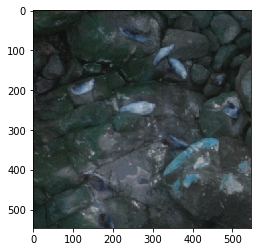

In [86]:
plt.imshow(im)

Predict probas:  [[[  5.30343175e-01   3.54608148e-01   2.72168443e-02   6.65284172e-02
     2.13033538e-02   6.11181576e-08]]]


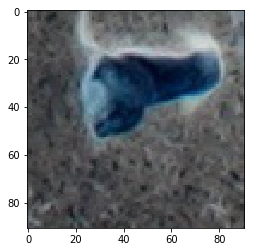

In [57]:
i = 8
plt.imshow(trainPatchesGenerator.denormalize_input(bx[i, ...]))
print("Predict probas: ", by_pred[i, ...])

In [73]:
im = cv2.imread("../data/sealion/TrainBlock/872_2.jpg")

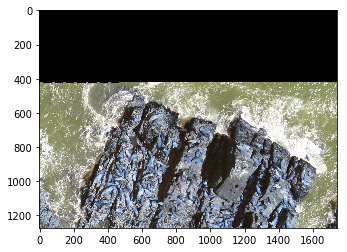

In [74]:
plt.imshow(im)

In [25]:
im = im.reshape((1, ) + im.shape)

In [28]:
im.dtype

dtype('uint8')

In [29]:
im_norm = trainPatchesGenerator.normalize_input(im.astype(np.float32))

In [31]:
y_pred = model.predict(im_norm)

In [33]:
im_norm.shape

(1, 1273, 1741, 3)

In [35]:
1741/91

19.13186813186813

In [32]:
y_pred.shape

(1, 38, 53, 6)

In [36]:
y_class = np.argmax(y_pred, axis=-1)

In [38]:
y_class.shape

(1, 38, 53)

In [42]:
y_pred

array([[[[ 0.16387215,  0.19384706,  0.03732777,  0.05518797,  0.03432254,
           0.51544243],
         [ 0.15472585,  0.18997875,  0.03572729,  0.05296258,  0.03257809,
           0.53402746],
         [ 0.16481817,  0.19557074,  0.0374341 ,  0.05509839,  0.03502308,
           0.51205552],
         ..., 
         [ 0.17431498,  0.20056191,  0.03904114,  0.05740699,  0.03694632,
           0.49172863],
         [ 0.15774742,  0.19332777,  0.03593099,  0.05348856,  0.03315451,
           0.5263508 ],
         [ 0.1566451 ,  0.19298066,  0.03582161,  0.05334541,  0.03301551,
           0.52819169]],

        [[ 0.17172749,  0.19930905,  0.03882855,  0.05726643,  0.03644937,
           0.49641916],
         [ 0.1683511 ,  0.19840001,  0.03828598,  0.05649861,  0.03583142,
           0.50263292],
         [ 0.17802107,  0.20227875,  0.0398428 ,  0.05842387,  0.03798033,
           0.48345318],
         ..., 
         [ 0.17360242,  0.20036663,  0.03899662,  0.05738107,  0.03689229,
  

In [40]:
y_class

array([[[5, 5, 5, ..., 5, 5, 5],
        [5, 5, 5, ..., 5, 5, 5],
        [5, 5, 5, ..., 5, 5, 5],
        ..., 
        [5, 5, 5, ..., 5, 5, 5],
        [5, 5, 5, ..., 5, 5, 5],
        [5, 5, 5, ..., 5, 5, 5]]])

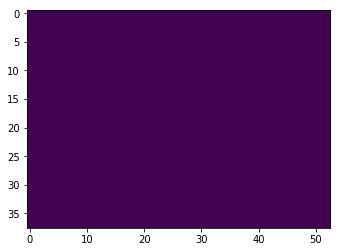

In [39]:
plt.imshow(y_class[0,:,:])